In [1]:
import cv2 as cv
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

## Loading

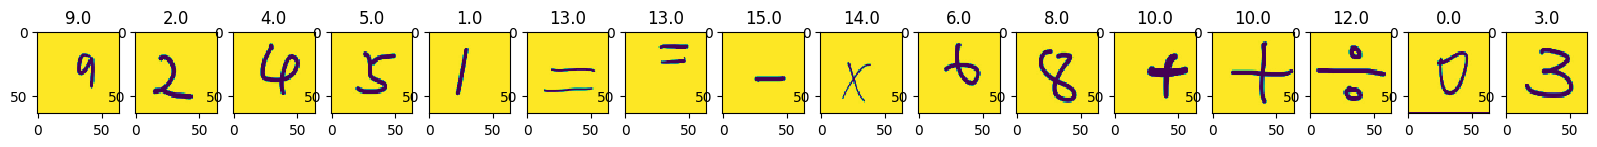

In [2]:
labels = {'0': 0, '1': 1, '2': 2, '3' : 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
          'add': 10, 'dec': 11, 'div': 12, 'eq': 13, 'mul': 14, 'sub': 15}

SZ = 64
resize_t = (SZ,SZ)

class DataLoader():
    def __init__(self, img_path, csv_path, img_size, ratio, label_dict):
        self.img_path = img_path
        self.csv_path = csv_path
        self.img_size = img_size
        self.img_len = self.img_size[0] * self.img_size[1]
        self.ratio = ratio
        self.label_dict = label_dict
        self.train_paths = []
        self.test_paths = []
    
    def load(self, path):
        img = cv.imread(path)
        img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        img = cv.resize(img, self.img_size, interpolation= cv.INTER_LINEAR)
        img = img.reshape(-1, self.img_len).astype(np.float32)/255
        features = img
        return features

    def split(self):
        self.train_paths = []
        self.test_paths = []
        df = pd.read_csv(self.csv_path)
        classes = set(df['label'])
        for c in classes:
            list_c = list(df.loc[df['label'] == c, 'file_path'])
            len_c = len(list_c)
            rd.shuffle(list_c)
            len_c_train = int(self.ratio * len_c)
            for i in range(len_c_train):
                self.train_paths.append((list_c[i], self.label_dict[c]))
            for i in range(len_c_train, len_c):
                self.test_paths.append((list_c[i], self.label_dict[c]))

    def create_datasets(self):
        self.split()
        train_len = len(self.train_paths)
        test_len = len(self.test_paths)
        train_data = np.zeros([train_len, self.img_len])
        train_label = np.zeros(train_len)
        test_data = np.zeros([test_len, self.img_len])
        test_label = np.zeros(test_len)
        for i in range(train_len):
            train_data[i,:] = self.load(self.img_path+ self.train_paths[i][0])
            train_label[i] = self.train_paths[i][1]

        for i in range(test_len):
            test_data[i,:] = self.load(self.img_path+ self.test_paths[i][0])
            test_label[i] = self.test_paths[i][1]

        return (train_data, train_label, test_data, test_label)

dl = DataLoader('archive/', 'archive/dataset.csv', resize_t, 0.8, labels)

train_data, train_label, test_data, test_label = dl.create_datasets()

fig, axs = plt.subplots(1, 16, figsize=(20, 3))
jump = 340
for i,ax in enumerate(axs):
    ax.imshow(train_data[i*jump].reshape(resize_t), interpolation='none')
    ax.set_title(train_label[i*jump])

plt.show()

## KNN

### Training

In [82]:
knn = cv.ml.KNearest_create()
knn.train(train_data.astype(np.float32), cv.ml.ROW_SAMPLE, train_label.astype(np.int64))


True

### Testing

Accuracy: 67.50809061488673 %


<Axes: >

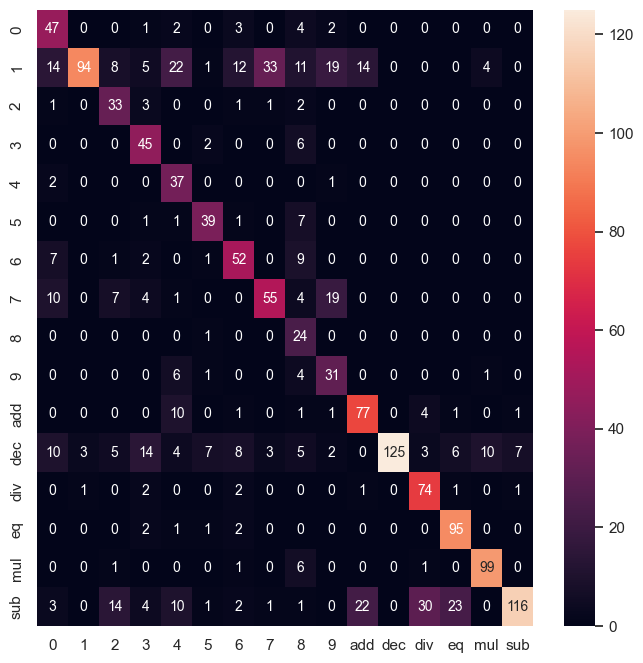

In [83]:
ret,result,neighbours,dist = knn.findNearest(test_data.astype(np.float32),k=1)

result = result.reshape(-1)
matches = result==test_label
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print("Accuracy: " + str(accuracy) + " %")


confusion_mat = np.zeros([len(labels), len(labels)])

for i in range(len(result)):
    confusion_mat[int(result[i]),int(test_label[i])] += 1

confusion_mat = confusion_mat.astype(int)
plt.figure(figsize = (8,8))
conf_df = pd.DataFrame(confusion_mat, labels, labels)
sn.set(font_scale=1)
sn.heatmap(conf_df, annot=True, annot_kws={"size": 10}, fmt='d')

[[15.]]


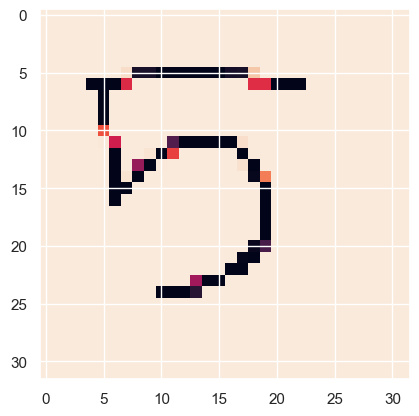

In [85]:
img_t = dl.load('5.png')
plt.imshow(img_t.reshape(resize_t))
ret, result, neighbours, dist = knn.findNearest(img_t, k=1)
print(result)

## SVM

### Features

In [3]:
# Copied from https://docs.opencv.org/3.4/dd/d3b/tutorial_py_svm_opencv.html

bin_n = 15 # Number of bins

def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...15)
    sz = int(SZ/2)
    bin_cells = bins[:sz,:sz], bins[sz:,:sz], bins[:sz,sz:], bins[sz:,sz:]
    mag_cells = mag[:sz,:sz], mag[sz:,:sz], mag[:sz,sz:], mag[sz:,sz:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n+1) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a vector of size 64
    return hist

train_hog = np.zeros((train_data.shape[0], 64))
test_hog = np.zeros((test_data.shape[0], 64))

for i in range(train_data.shape[0]):
    img = train_data[i,:].reshape(resize_t)
    img = img.astype(np.float32)
    hog_i = hog(img)
    train_hog[i,:] = hog_i

for i in range(test_data.shape[0]):
    img = test_data[i,:].reshape(resize_t)
    img = img.astype(np.float32)
    hog_i = hog(img)
    test_hog[i,:] = hog_i


### Training

In [4]:
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_INTER)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)
svm.train(train_hog.astype(np.float32), cv.ml.ROW_SAMPLE, train_label.astype(np.int64))
svm.save('svm_data.dat')

### Test

Accuracy: 93.20388349514563 %


<Axes: >

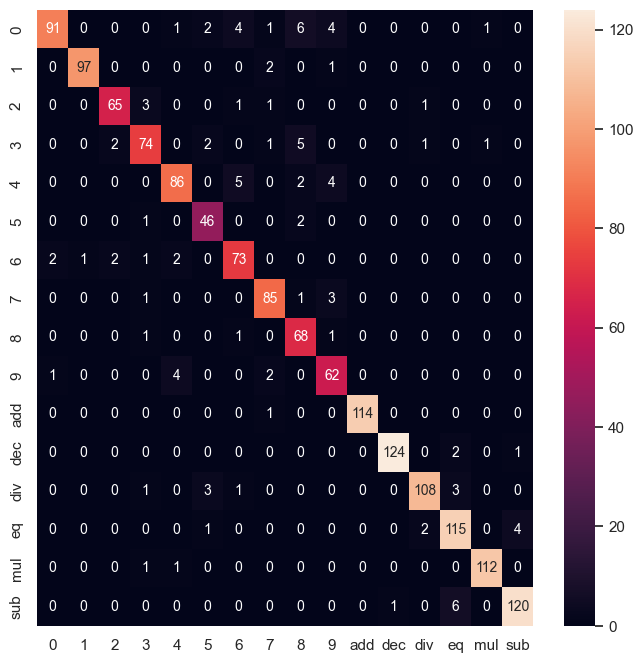

In [27]:
result = svm.predict(test_hog.astype(np.float32))[1]

result = result.reshape(-1)
matches = result==test_label.astype(np.int64)
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print("Accuracy: " + str(accuracy) + " %")


confusion_mat = np.zeros([len(labels), len(labels)])

for i in range(len(result)):
    confusion_mat[int(result[i]),int(test_label[i])] += 1

confusion_mat = confusion_mat.astype(int)
plt.figure(figsize = (8,8))
conf_df = pd.DataFrame(confusion_mat, labels, labels)
sn.set(font_scale=1)
sn.heatmap(conf_df, annot=True, annot_kws={"size": 10}, fmt='d')

[[2.]]


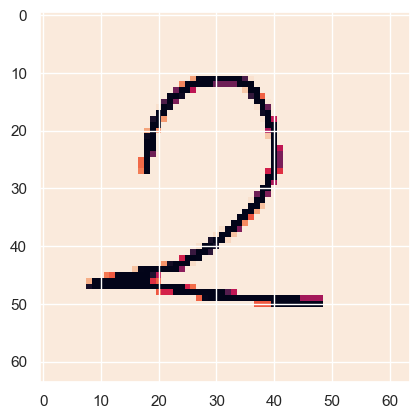

In [39]:
img_t = dl.load('2.png').reshape(resize_t)
plt.imshow(img_t)
hog_t = hog(img_t).reshape(1,64)
res = svm.predict(hog_t.astype(np.float32))[1]
print(res)